# Introduction to Bedrock - Building with Bedrock Embeddings

> *If you see errors, you may need to be allow-listed for the Bedrock models used by this notebook*

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*


In this demo notebook, we demonstrate how to use the Bedrock Python SDK for Embeddings Generation.

1. [Set Up](#1.-Set-Up)
2. [Embeddings Generation](#2.-Embeddings-Generation)
3. [Semantic Similarity](#3.-Semantic-Similarity)

Note: This notebook was tested in Amazon SageMaker Studio with Python 3 (Data Science 2.0) kernel.

### 1. Set Up

In [2]:
%pip install -U boto3 botocore --force-reinstall --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
apache-beam 2.50.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.0 which is incompatible.
awscli 1.29.57 requires botocore==1.31.57, but you have botocore 1.31.62 which is incompatible.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.3.3 which is incompatible.
jupyterlab 3.4.4 requires jupyter-server~=1.16, but you have jupyter-server 2.7.3 which is incompatible.
jupyterlab-server 2.10.3 requires jupyter-server~=1.4, but you have jupyter-server 2.7.3 which is incompatible.
llama-index 0.8.37 requires urllib3<2, but you have urllib3 2.0.6 which is incompatible.
opensearch-py 2.3.1 requires urllib3<2,>=1.21.1, but you have urllib3 2.0.6 which is incompatible.

#### Now let's set up our connection to the Amazon Bedrock SDK using Boto3

In [3]:
#### Un comment the following lines to run from your local environment outside of the AWS account with Bedrock access

#import os
#os.environ['BEDROCK_ASSUME_ROLE'] = '<YOUR_VALUES>'
#os.environ['AWS_PROFILE'] = '<YOUR_VALUES>'

In [4]:
import boto3
import json 

bedrock = boto3.client(service_name="bedrock")
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

Create new client
  Using region: us-west-2
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)


### 2. Embeddings Generation

Embeddings are a key concept in generative AI and machine learning in general. An embedding is a representation of an object (like a word, image, video, etc.) in a vector space. Typically, semantically similar objects will have embeddings that are close together in the vector space. These are very powerful for use-cases like semantic search, recommendations and Classifications.

In [5]:
# We will be using the Titan Embeddings Model to generate our Embeddings.

def get_embedding(body, modelId, accept, contentType):
    response = bedrock_runtime.invoke_model(
        body=body, 
        modelId=modelId, 
        accept=accept, 
        contentType=contentType
    )
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get('embedding')
    return embedding

body = json.dumps({"inputText": "explain generative AI to 5th graders"})
modelId = 'amazon.titan-embed-text-v1'
accept = 'application/json'
contentType = 'application/json'

embedding = get_embedding(body, modelId, accept, contentType)
print(embedding[0:10])

[-0.4296875, -0.47070312, -0.375, 0.107421875, 0.38867188, -0.17382812, -0.42773438, -0.00051116943, 0.22949219, 0.25195312]


### 3. Semantic Similarity

A use case of sentence embedding is to cluster together sentences with similar semantic meaning.  In the example below we compute the embeddings of sentences in three categories: pets, cities in the U.S., and color.  We see that sentences originating from the same category have much closer embedding vectors than those from different categories.  Specifically, the code will do the following:
The Bedrock embedding API will output an embedding vector for each sentence;  The distance between any pair of sentences is computed by the cosine similarity of corresponded embedding vectors;A heatmap is created to visualize the distance between any pair of sentences in the embedding space. Darker the color, larger the cosine similarity (smaller the distance).
Note. Cosine similarity of two vectors is  the inner product of the normalized vectors (scale down to have length 1).

In [6]:
import sklearn
from sklearn.preprocessing import normalize
import numpy as np
import seaborn as sns


def plot_similarity_heatmap(text_labels, embeddings, rotation):
    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="BuPu",
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")


phrases = [
    # Animals
    "Shelbee's dog, Molly, is so cute.",
    "Antje hates cats.",
    "Chris' first dog was very cute.",
    # U.S. Cities
    "Chicago is the place where I'm from.",
    "I work in San Francisco.",
    "Washington D.C. is a great place to visit.",
    # Color
    "What is your favorite color?",
    "Is Molly brown?",
    "Are your eyes blue?"
]

embeddings = []

for phrase in phrases:
    query_response = get_embedding(
      body=json.dumps({"inputText": phrase}),
      modelId='amazon.titan-embed-text-v1', 
      accept='application/json', 
      contentType='application/json')

    embeddings.append(query_response)
    
embeddings = normalize(np.array(embeddings), axis=1)  # normalization before inner product

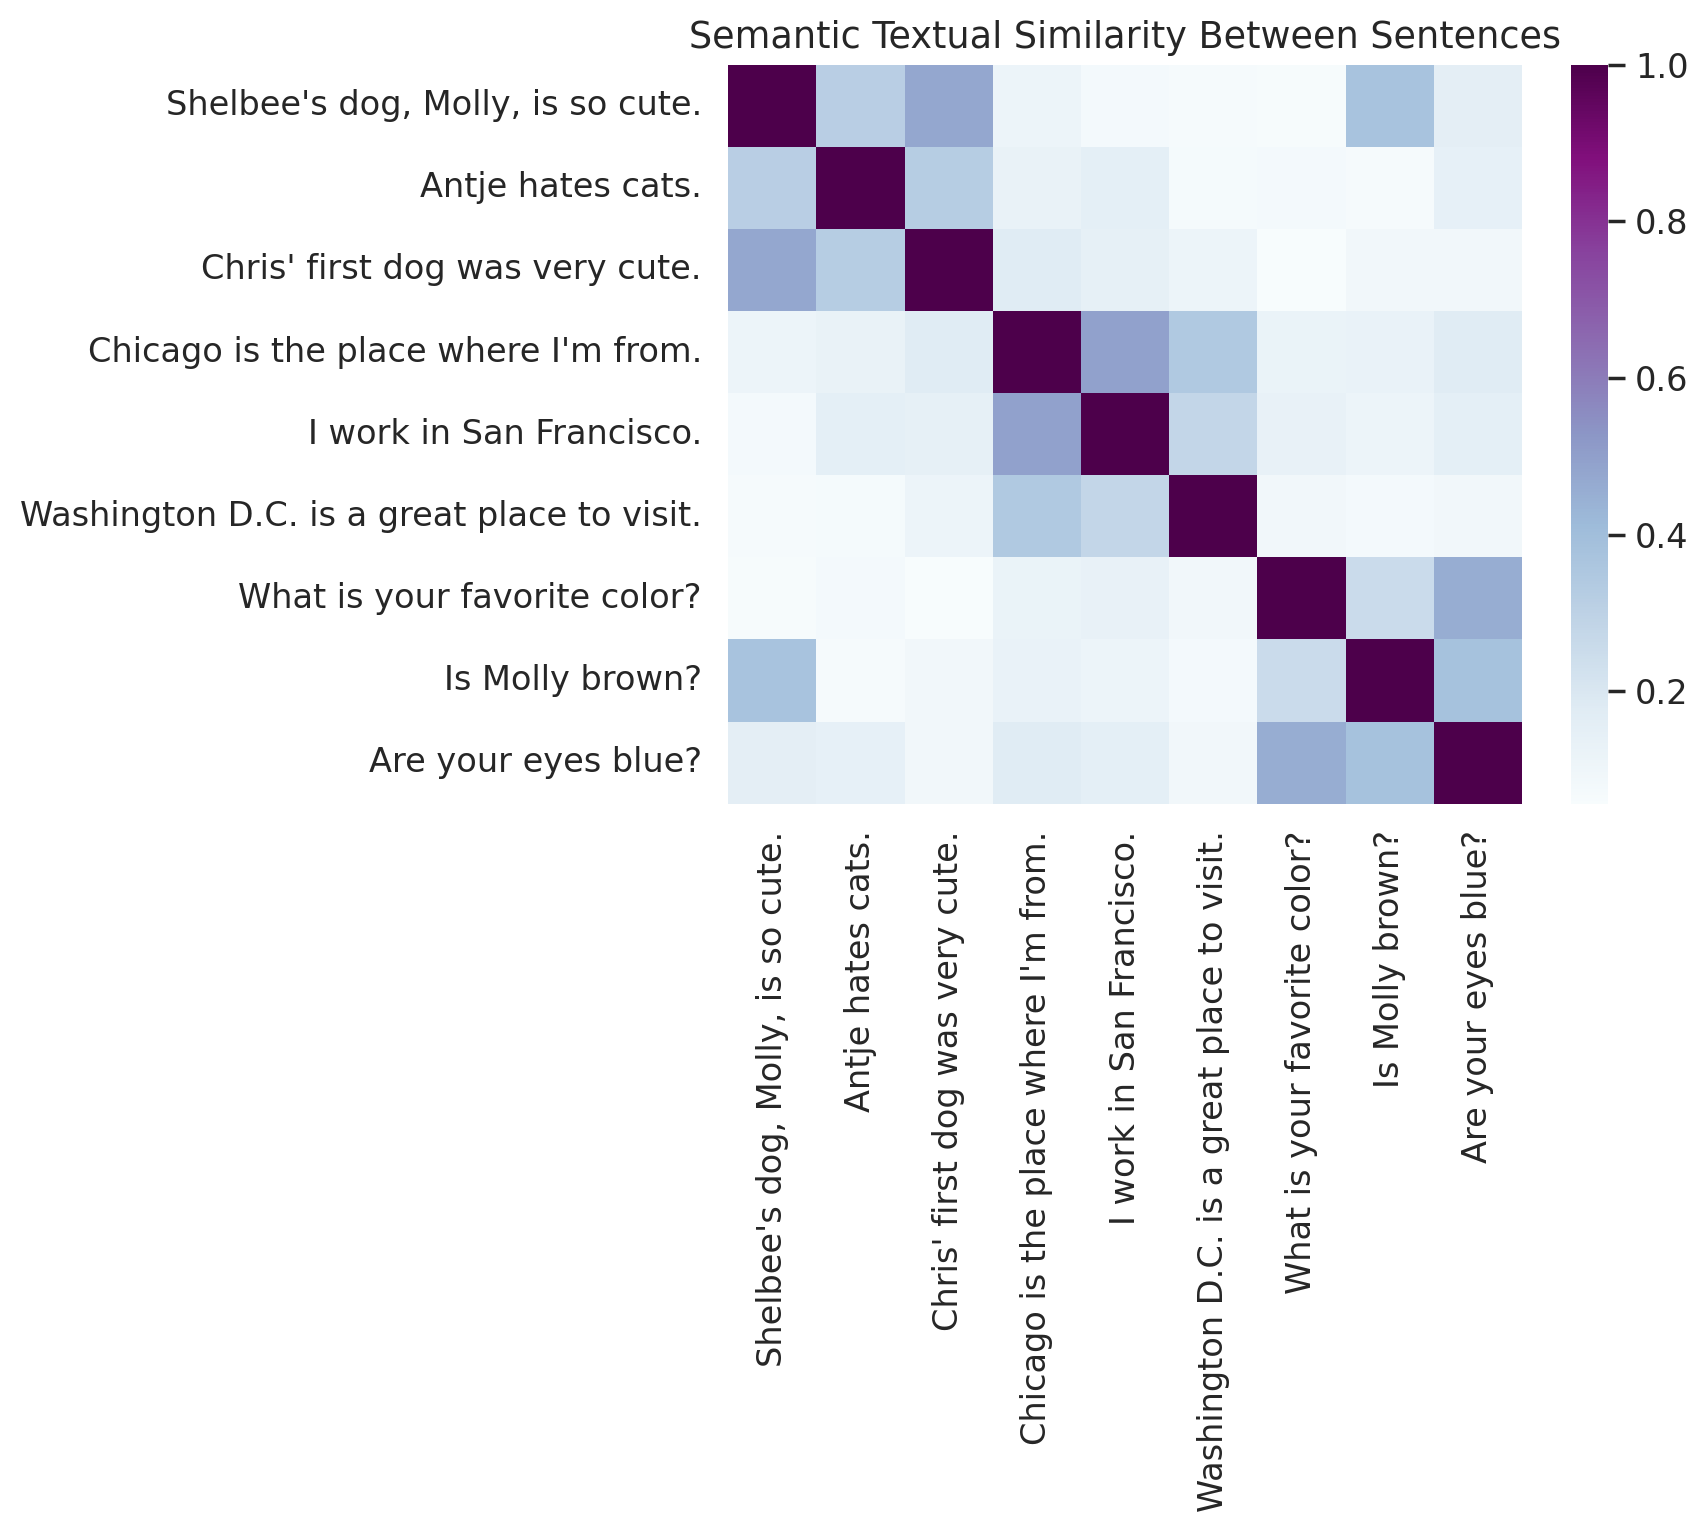

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plot_similarity_heatmap(phrases, embeddings, 90)